In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import os
#os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [3]:
# Dataset directions
Dataset_max_len_Padded_dir = r'D:\Animation\HWs\02\Dataset_max_len_Padded.npy'

In [4]:
# Loading dataset
Dataset = np.load(Dataset_max_len_Padded_dir)
print('Shape of dataset: ' + str(Dataset.shape))

Shape of dataset: (215, 35, 48)


In [5]:
# Global variables
videos_len = Dataset[-1, 0, 0].astype(int) + 1
actors_len = Dataset[-1, 0, 1].astype(int) + 1
action_classes = ['wave', 'drink from bottle', 'answer phone', 'clap', 'tight lace', 'sit down', 'stand up', 'read watch', 'bow']

In [6]:
# Determine length of videos
vid_len = Dataset.shape[1]

In [7]:
# Define Labels array
y_actions = np.zeros(Dataset.shape[0])
y_actors = np.zeros(Dataset.shape[0])
for vid_index in range(Dataset.shape[0]):
    y_actions[vid_index] = Dataset[vid_index, 0, 2]
    y_actors[vid_index] = Dataset[vid_index, 0, 1]

In [8]:
# Transform labels to one-hot (categorical)
from keras.utils import to_categorical

y_actions_cat = to_categorical(y_actions)
print('Shape of categorical-labels: ' + str(y_actions_cat.shape))

Using TensorFlow backend.


Shape of categorical-labels: (215, 9)


In [9]:
# Define X
X = Dataset[:, :, 3:]
print('Shape of X: ' + str(X.shape))

Shape of X: (215, 35, 45)


In [10]:
# Train and test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y_actions_cat, test_size=0.1, random_state=10, stratify=y_actions_cat)

In [11]:
# LSTM 1-layer
from keras import layers, models

model=models.Sequential()

model.add(layers.LSTM(512, input_shape=(X.shape[1], X.shape[2])))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(9, activation='softmax'))

In [12]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 512)               1142784   
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_2 (Dense)              (None, 9)                 1161      
Total params: 1,209,609
Trainable params: 1,209,609
Non-trainable params: 0
_________________________________________________________________


In [13]:
# Compiling model
from keras import optimizers

model.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(lr=1e-4), metrics=['acc'])

In [14]:
# Fitting and trainig model
history = model.fit(X_train, y_train, batch_size=64, epochs=100, validation_split=0.2)

Train on 154 samples, validate on 39 samples
Epoch 1/100
154/154 [==============================] - 1s 5ms/step - loss: 2.1801 - acc: 0.2208 - val_loss: 2.1586 - val_acc: 0.3333
Epoch 2/100
154/154 [==============================] - 1s 4ms/step - loss: 2.1041 - acc: 0.4416 - val_loss: 2.1041 - val_acc: 0.2051
Epoch 3/100
154/154 [==============================] - 1s 4ms/step - loss: 1.9806 - acc: 0.3247 - val_loss: 2.0450 - val_acc: 0.1538
Epoch 4/100
154/154 [==============================] - 1s 4ms/step - loss: 1.8610 - acc: 0.3182 - val_loss: 2.0063 - val_acc: 0.2051
Epoch 5/100
154/154 [==============================] - 1s 4ms/step - loss: 1.7650 - acc: 0.3182 - val_loss: 1.9202 - val_acc: 0.2821
Epoch 6/100
154/154 [==============================] - 1s 4ms/step - loss: 1.7040 - acc: 0.3896 - val_loss: 1.8570 - val_acc: 0.2821
Epoch 7/100
154/154 [==============================] - 1s 4ms/step - loss: 1.6293 - acc: 0.4286 - val_loss: 1.8252 - val_acc: 0.2308
Epoch 8/100
154/154 [===

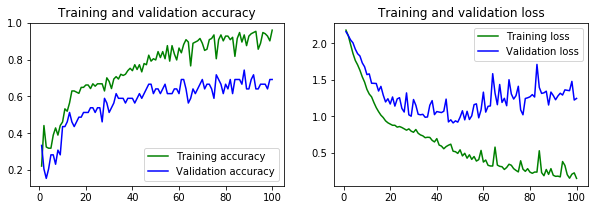

In [16]:
# Show curves of loss and accuracy during training
accuracy=history.history['acc']
validation_accuracy=history.history['val_acc']
loss=history.history['loss']
validation_loss=history.history['val_loss']
epochs=range(1, len(accuracy)+1)

plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
plt.plot(epochs, accuracy, 'g', label='Training accuracy')
plt.plot(epochs, validation_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, validation_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [15]:
# Evaluate model on data
score=model.evaluate(X_test, y_test, batch_size=64)
print(score)

22/22 [==============================] - 0s 1ms/step
[0.9408140778541565, 0.7727272510528564]


In [18]:
# Get the predictions from model
preds = model.predict(X_test)

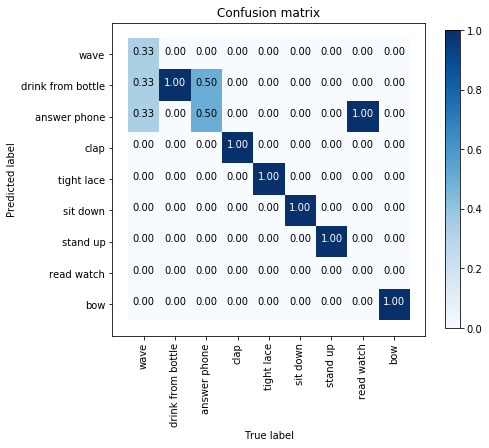

In [19]:
from sklearn.metrics import confusion_matrix
import itertools

conf_mtx = confusion_matrix(np.argmax(preds, axis=1), np.argmax(y_test, axis=1))
conf_mtx = conf_mtx / conf_mtx.sum(axis=0)

plt.figure(figsize=(7,7))
plt.imshow(conf_mtx, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar(shrink=.7)
tick_marks = np.arange(len(action_classes))
plt.xticks(tick_marks, action_classes, rotation=90)
plt.yticks(tick_marks, action_classes)
fmt = '.2f'
thresh = conf_mtx.max() / 2.
for i, j in itertools.product(range(conf_mtx.shape[0]), range(conf_mtx.shape[1])):
    plt.text(j, i, format(conf_mtx[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if conf_mtx[i, j] > thresh else "black")
        
plt.tight_layout()
plt.axis([-1,9,9,-1])
plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.show()

In [20]:
# Mean accuracy
np.mean(np.diag(conf_mtx))

0.7592592592592592

In [43]:
# LSTM 2-layer
model2=models.Sequential()

model2.add(layers.LSTM(512, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model2.add(layers.LSTM(512))
model2.add(layers.Dense(128, activation='relu'))
model2.add(layers.Dense(9, activation='softmax'))

In [44]:
model2.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_17 (LSTM)               (None, 35, 512)           1142784   
_________________________________________________________________
lstm_18 (LSTM)               (None, 512)               2099200   
_________________________________________________________________
dense_11 (Dense)             (None, 128)               65664     
_________________________________________________________________
dense_12 (Dense)             (None, 9)                 1161      
Total params: 3,308,809
Trainable params: 3,308,809
Non-trainable params: 0
_________________________________________________________________


In [45]:
# Compiling model
from keras import optimizers

model2.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(lr=1e-4), metrics=['acc'])

In [46]:
# Fitting and trainig model
history = model2.fit(X_train, y_train, batch_size=64, epochs=50, validation_split=0.2)

Train on 154 samples, validate on 39 samples
Epoch 1/50
154/154 [==============================] - 2s 12ms/step - loss: 2.1635 - acc: 0.2532 - val_loss: 2.1014 - val_acc: 0.2051
Epoch 2/50
154/154 [==============================] - 1s 9ms/step - loss: 1.9864 - acc: 0.3247 - val_loss: 1.9797 - val_acc: 0.2564
Epoch 3/50
154/154 [==============================] - 1s 9ms/step - loss: 1.8062 - acc: 0.3052 - val_loss: 1.8734 - val_acc: 0.2051
Epoch 4/50
154/154 [==============================] - 1s 9ms/step - loss: 1.6629 - acc: 0.3506 - val_loss: 1.8660 - val_acc: 0.1795
Epoch 5/50
154/154 [==============================] - 1s 9ms/step - loss: 1.5758 - acc: 0.3377 - val_loss: 1.7318 - val_acc: 0.2051
Epoch 6/50
154/154 [==============================] - 1s 9ms/step - loss: 1.4498 - acc: 0.4286 - val_loss: 1.5222 - val_acc: 0.4359
Epoch 7/50
154/154 [==============================] - 1s 9ms/step - loss: 1.3468 - acc: 0.5130 - val_loss: 1.4650 - val_acc: 0.4359
Epoch 8/50
154/154 [==========

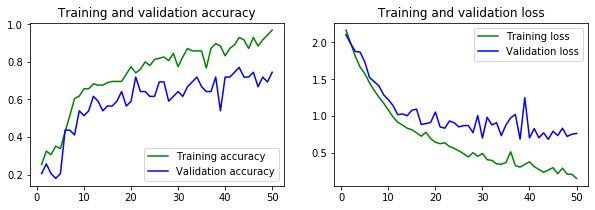

In [47]:
# Show curves of loss and accuracy during training
accuracy=history.history['acc']
validation_accuracy=history.history['val_acc']
loss=history.history['loss']
validation_loss=history.history['val_loss']
epochs=range(1, len(accuracy)+1)

plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
plt.plot(epochs, accuracy, 'g', label='Training accuracy')
plt.plot(epochs, validation_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, validation_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [48]:
# Evaluate model on data
score=model2.evaluate(X_test, y_test, batch_size=64)
print(score)

22/22 [==============================] - 0s 3ms/step
[0.9574260711669922, 0.6818181872367859]


In [50]:
# Get the predictions from model
preds = model2.predict(X_test)

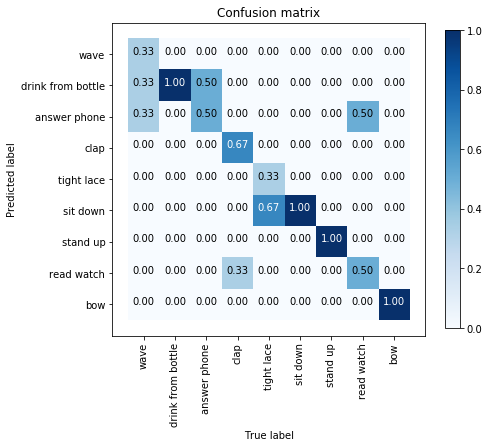

In [51]:
from sklearn.metrics import confusion_matrix
import itertools

conf_mtx = confusion_matrix(np.argmax(preds, axis=1), np.argmax(y_test, axis=1))
conf_mtx = conf_mtx / conf_mtx.sum(axis=0)

plt.figure(figsize=(7,7))
plt.imshow(conf_mtx, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar(shrink=.7)
tick_marks = np.arange(len(action_classes))
plt.xticks(tick_marks, action_classes, rotation=90)
plt.yticks(tick_marks, action_classes)
fmt = '.2f'
thresh = conf_mtx.max() / 2.
for i, j in itertools.product(range(conf_mtx.shape[0]), range(conf_mtx.shape[1])):
    plt.text(j, i, format(conf_mtx[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if conf_mtx[i, j] > thresh else "black")
        
plt.tight_layout()
plt.axis([-1,9,9,-1])
plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.show()

In [52]:
# Mean accuracy
np.mean(np.diag(conf_mtx))

0.7037037037037037